In [38]:
from emukit.test_functions.multi_fidelity import multi_fidelity_borehole_function
from emukit.examples.multi_fidelity_dgp.baseline_model_wrappers import LinearAutoRegressiveModel

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])

borehole = Function(name='borehole', y_scale=100, noise_level=[0.05, 0.1], do_x_scaling=True, num_data=[60, 5], 
                    fcn=multi_fidelity_borehole_function)

In [40]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [41]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [42]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign

In [43]:
np.random.seed(123)

x_test, y_test, X, Y = generate_data(borehole, 1000)

m1 =  LinearAutoRegressiveModel(X, Y)
m1.optimize()

#print(X[0])

(5, 8)


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Optimization restart 1/10, f = -178.24657906975077
Optimization restart 2/10, f = -181.63715525087008


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/10, f = -143.75573345076776
Optimization restart 4/10, f = -177.01959823734686
Optimization restart 5/10, f = -180.4559365412607
Optimization restart 6/10, f = -162.5373948424491
Optimization restart 7/10, f = -157.51775358193706
Optimization restart 8/10, f = -147.65205857872337
Optimization restart 9/10, f = -180.25580258815634
Optimization restart 10/10, f = -183.33255893996102


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = -187.0280538299873
Optimization restart 2/10, f = -186.66262957504057
Optimization restart 3/10, f = -185.575639392197
Optimization restart 4/10, f = -181.6008756064383
Optimization restart 5/10, f = -164.72629803233718
Optimization restart 6/10, f = -177.59187523091572
Optimization restart 7/10, f = -187.36243454863302
Optimization restart 8/10, f = -185.59042510602472
Optimization restart 9/10, f = -164.81603868156986
Optimization restart 10/10, f = -187.04969720187813


In [44]:
y_mean, y_var = m1.predict(x_test)

In [45]:
import scipy.stats

print(calculate_metrics(y_test, y_mean, y_var))

{'r2': 0.9999146445873958, 'rmse': 0.004173239559319285, 'mnll': -3.941176045649081}


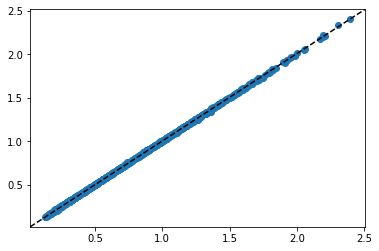

In [46]:
import matplotlib.pyplot as plt

plt.scatter(y_mean,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

In [47]:
#from emukit.examples.multi_fidelity_dgp.multi_fidelity_deep_gp import MultiFidelityDeepGP

In [48]:
#mf_dgp_fix_lf_mean = MultiFidelityDeepGP(X, Y, n_iter=500)
#mf_dgp_fix_lf_mean.optimize()

In [49]:
#y_mean_dgp, y_var_dgp = mf_dgp_fix_lf_mean.predict(x_test)

In [50]:
#print(calculate_metrics(y_test, y_mean_dgp, y_var_dgp))

In [51]:
#plt.scatter(y_mean_dgp,y_test)
#plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.show()

In [52]:
from MFRBF import MFRBF

In [53]:
X_currin_cheap = X[0]
X_currin_expensive = X[1]

y_currin_cheap = Y[0]
y_currin_expensive = Y[1]

import GPy
from GPy.kern import Kern
from GPy import Param, Model

m4 = GPy.models.GPRegression(X_currin_cheap, y_currin_cheap)
m4.optimize()

In [54]:
m4.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -64.51305805771757
Optimization restart 2/10, f = -63.656280020372805
Optimization restart 3/10, f = -64.51305805743513
Optimization restart 4/10, f = -64.51305805780781
Optimization restart 5/10, f = -64.51305805773833
Optimization restart 6/10, f = -63.594930710036124
Optimization restart 7/10, f = -64.51305805700039
Optimization restart 8/10, f = -64.51305805778904
Optimization restart 9/10, f = -64.51305805772017
Optimization restart 10/10, f = -64.51305805782278


In [55]:
mu_currin, v_currin = m4.predict(X_currin_expensive, full_cov = True)

kern_currin = MFRBF(input_dim=X_currin_expensive.shape[1], variance = 10, lengthscale = 1, mu = mu_currin, v=v_currin)
#k_currin_1 = deepKern.K(X_currin_expensive)

k_currin_rbf = GPy.kern.RBF(input_dim = X_currin_expensive.shape[1])

k_currin = kern_currin * k_currin_rbf

m_currin = GPy.models.GPRegression(X_currin_expensive, y_currin_expensive, k_currin)

m_currin.optimize()

In [56]:
m_currin.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -1.3776361295038466
Optimization restart 2/10, f = 6.857006505334294
Optimization restart 3/10, f = -1.3776361295732258
Optimization restart 4/10, f = 6.857006533104827
Optimization restart 5/10, f = 6.857006533104827
Optimization restart 6/10, f = -1.3776361295807487
Optimization restart 7/10, f = -1.3776361282593594
Optimization restart 8/10, f = 6.857006533109654
Optimization restart 9/10, f = 6.857006533107417
Optimization restart 10/10, f = -1.4427608937860548


In [57]:
X_test = x_test[:,0:8]

In [58]:
def predict_eff(CovMtx, Y):
    K_ee = CovMtx[1:,1:]
    K_e = CovMtx[0,1:]
    K_inv = np.linalg.inv(K_ee+0.0001*np.eye(K_ee.shape[0]))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0,0] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, pred_v


In [59]:
s1=m_currin.kern.rbf.variance[0]
l1=m_currin.kern.rbf.lengthscale[0]
s2=m_currin.kern.MFRBF.variance[0]
l2=m_currin.kern.MFRBF.lengthscale[0]


Y_test=[]
Y_test_cov = []
Y_test_up=[]
Y_test_down=[]

for i in range(X_test.shape[0]):
    xx = X_test[i].reshape(1,8)
    Xnew = np.vstack((xx,X_currin_expensive))
    mu1, v1 = m4.predict(Xnew, full_cov = True)
    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
    M1 = kernMF.K(Xnew)
    M2 = kernRBF.K(Xnew)
    GG = np.multiply(M1, M2)
    
    pred_mu, pred_var = predict_eff(GG, y_currin_expensive)
    
    Y_test.append(pred_mu)
    Y_test_cov.append(pred_var)
    #Y_test_up.append(pred_mu+1.96*pred_std)
    #Y_test_down.append(pred_mu-1.96*pred_std)
    
mfgp_mean = np.array(Y_test).reshape(-1,1)
mfgp_var = np.array(Y_test_cov).reshape(-1,1)
print(calculate_metrics(y_test, mfgp_mean, mfgp_var))    

{'r2': 0.9941037313444914, 'rmse': 0.03468537659374032, 'mnll': -2.075767451799348}


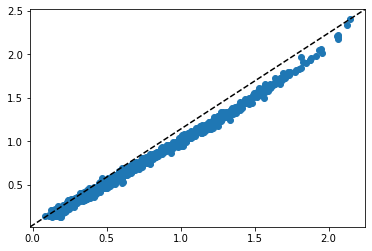

In [60]:
plt.scatter(mfgp_mean,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [61]:
xx_test = x_test[:,0:8]
xx_test.shape

(1000, 8)

In [62]:
def predict_eff_new(CovMtx, Y):
    len_expensive = Y.shape[0]
    len_all = CovMtx.shape[0]
    len_high = len_all-len_expensive
    K_ee = CovMtx[len_high:,len_high:]
    K_e = CovMtx[0:len_high,len_high:]
    K_inv = np.linalg.inv(K_ee+0.000001*np.eye(len_expensive))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0:len_high,0:len_high] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, pred_v

In [63]:
Xnew1 = np.vstack((xx_test,X_currin_expensive))
mu_new, v_new = m4.predict(Xnew1, full_cov = True)

mu_new.shape, v_new.shape

((1005, 1), (1005, 1005))

In [64]:
kernMF_new = MFRBF(input_dim=2, variance = s2, lengthscale = l2, mu = mu_new, v=v_new)
kernRBF_new = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)

M1_new = kernMF_new.K(Xnew1)
M2_new = kernRBF_new.K(Xnew1)
GG_new = np.multiply(M1_new, M2_new)

M1_new.shape, M2_new.shape

pred_mu_new, pred_var_new = predict_eff_new(GG_new, y_currin_expensive)

In [65]:
pred_mu_new.shape, pred_var_new.shape

((1000, 1), (1000, 1000))

In [66]:
new_var = np.diagonal(pred_var_new).reshape(-1,1)
new_var.shape

(1000, 1)

In [67]:
print(calculate_metrics(y_test, pred_mu_new, new_var)) 

{'r2': 0.994237971612133, 'rmse': 0.03428826256115812, 'mnll': -2.0830310303435007}
